# Floor plans in a PolyGen Network

So much water has flown under the bridges.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-configuration" data-toc-modified-id="Imports-and-configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and configuration</a></span><ul class="toc-item"><li><span><a href="#Load-floorplan-XML-files" data-toc-modified-id="Load-floorplan-XML-files-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load floorplan XML files</a></span></li></ul></li><li><span><a href="#Dealing-with-Polylines-and-Paths" data-toc-modified-id="Dealing-with-Polylines-and-Paths-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dealing with Polylines and Paths</a></span><ul class="toc-item"><li><span><a href="#Path-utilities" data-toc-modified-id="Path-utilities-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Path utilities</a></span></li><li><span><a href="#Polyline-Sets" data-toc-modified-id="Polyline-Sets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Polyline Sets</a></span></li><li><span><a href="#Flattening-and-Unflattening" data-toc-modified-id="Flattening-and-Unflattening-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Flattening and Unflattening</a></span><ul class="toc-item"><li><span><a href="#Plot-All-Floorplans" data-toc-modified-id="Plot-All-Floorplans-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Plot All Floorplans</a></span></li></ul></li></ul></li><li><span><a href="#Generating-Training-Data" data-toc-modified-id="Generating-Training-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generating Training Data</a></span><ul class="toc-item"><li><span><a href="#Subdividing-Polylines" data-toc-modified-id="Subdividing-Polylines-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Subdividing Polylines</a></span></li><li><span><a href="#Aside:-Intersecting-Paths" data-toc-modified-id="Aside:-Intersecting-Paths-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Aside: Intersecting Paths</a></span></li><li><span><a href="#Generating-Valid-Positions" data-toc-modified-id="Generating-Valid-Positions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generating Valid Positions</a></span></li><li><span><a href="#Spacing-the-Positions-Maximally" data-toc-modified-id="Spacing-the-Positions-Maximally-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Spacing the Positions Maximally</a></span></li><li><span><a href="#Sorting-the-Line-Segments" data-toc-modified-id="Sorting-the-Line-Segments-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Sorting the Line Segments</a></span></li><li><span><a href="#Overlap-Deduplication" data-toc-modified-id="Overlap-Deduplication-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Overlap Deduplication</a></span></li><li><span><a href="#Splitting-at-Intersections" data-toc-modified-id="Splitting-at-Intersections-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Splitting at Intersections</a></span></li><li><span><a href="#Dedupe,-Split,-Subdivide,-Sort" data-toc-modified-id="Dedupe,-Split,-Subdivide,-Sort-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Dedupe, Split, Subdivide, Sort</a></span></li><li><span><a href="#Applying-to-All-Floorplans" data-toc-modified-id="Applying-to-All-Floorplans-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Applying to All Floorplans</a></span></li><li><span><a href="#Training-and-validation-TF-datasets" data-toc-modified-id="Training-and-validation-TF-datasets-3.10"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>Training and validation TF datasets</a></span></li></ul></li></ul></li></ul></div>

## Imports and configuration

In [1]:
%env CUDA_VISIBLE_DEVICES=0
import os
import datetime
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'^Passing .* as a synonym')
    import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # Hide TF deprecation messages
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
from pathlib import Path

import modules
import modules_polyline
import data_utils
import floorplans

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# Note that most of these only make sense once you
# understand the rest of this notebook.

# Quantization bits
n_bits = 8

# The length of a QU in meters is scale/(2**n_bits).
QU = 2**n_bits

# Number of positions to pick sampling locations from.
num_positions = 300

# Sensor range determines the maximum overlap between sampled locations.
sensor_rangef = lambda scale: 3.5/scale*QU 

# Number of nearest segments to keep for each generated sample.
num_segments = 50

# Compute maximum segment length for a given scale.
max_seg_lenf = lambda scale: 5/scale*QU

# Doesn't actually work for some reason.
memory_efficient = False

# If you want to change the quantization, change the code.
assert n_bits == data_utils.QUANTIZATION_BITS

# Don't eat all GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

### Load floorplan XML files

In [3]:
floorplans_dataset_dir = Path('~/ds/KTH_CampusValhallavagen_Floorplan_Dataset_RAW').expanduser()
assert floorplans_dataset_dir.exists()
floorplan_xmls = list(floorplans_dataset_dir.glob('*/*.xml'))
#floorplan_xmls = list(floorplans_dataset_dir.glob('A0043022/*.xml'))
print(f'{len(floorplan_xmls)} floorplan xml files')
all_floorplans = floorplans.load_all(floorplan_xmls)

171 floorplan xml files


## Dealing with Polylines and Paths

### Path utilities

In [4]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path as MPath
#from matplotlib.collections import LineCollection as MLineCollection


def floorplan_to_path(fplan: floorplans.FloorPlan, *, recenter=True) -> MPath:
    lines = [line for s in fplan.spaces for line in s.lines
             if line.kind.casefold() != 'portal']

    verts = [lines[0].start]
    codes = [MPath.MOVETO]
    for line in lines:
        if not np.allclose(line.start, verts[-1]):
            verts.append(line.start)
            codes.append(MPath.MOVETO)
        verts.append(line.end)
        codes.append(MPath.LINETO)

    verts = np.array(verts)
    codes = np.array(codes)

    if recenter:
        center, _ = data_utils.find_center_scale(verts)
        verts -= center

    return MPath(verts, codes)


a_floorplan = all_floorplans[0]
path = floorplan_to_path(a_floorplan)

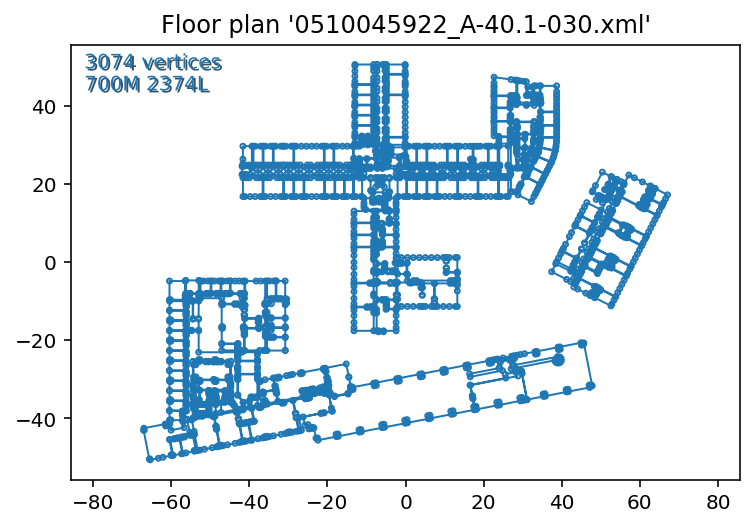

In [5]:
import collections
from matplotlib import patheffects as mpe

code_names = {MPath.MOVETO: 'M',
              MPath.LINETO: 'L'}


def plot_path(path, *, autoscale=True, ax=None, fig=None, text=True, vert_size=6,
              label=None, text_x=0.02, text_y=0.98, text_va='top', shift=0.0,
              color='C0', zorder=0, **kw):

    fig = plt.gcf() if fig is None else fig
    ax  = fig.gca() if ax is None else ax

    kw.setdefault('facecolor', 'None')

    path = MPath(path.vertices + shift, path.codes)
    ax.add_patch(PathPatch(path, edgecolor=color, **kw))

    plot_verts = np.unique(path.vertices, axis=0)
    ax.scatter(plot_verts[:, 0], plot_verts[:, 1], s=vert_size,
               color=color, label=label, **kw)

    if autoscale:
        ax.autoscale()

    if text:
        counts = collections.Counter(path.codes)
        parts = [f'{counts.pop(code, 0)}{name}' for code, name in code_names.items()]
        if counts:
            parts.append(f'?i{sum(counts.values())}')

        lines = [label,
                 f'{len(path.vertices)} vertices',
                 ' '.join(parts)]

        s = '\n'.join(filter(None, lines))
        t = ax.text(text_x, text_y, s, transform=ax.transAxes,
                    va=text_va, color=color, alpha=kw.get('alpha'),
                    zorder=kw.get('zorder', 0)+1e3)
        shadow = mpe.withSimplePatchShadow(offset=(1, -1),
                                           alpha=0.8*kw.get('alpha', 1.0))
        t.set_path_effects([shadow])
        

def plot_paths(paths, fig_size=(4.0, 4/3), n_cols=3, **kw):
    n_plot = len(paths)
    n_cols = np.minimum(n_plot, n_cols)
    n_rows = int(np.ceil(n_plot / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, sharex='all', sharey='all', squeeze=False,
                            subplot_kw=dict(adjustable='box', aspect='equal'),
                            figsize=fig_size*np.r_[n_cols, n_rows])
    for i, path in enumerate(paths):
        row, col = np.divmod(i, n_cols)
        plot_path(path, ax=axs[row, col], fig=fig, **kw)
    for i in range(n_plot, n_cols*n_rows):
        row, col = np.divmod(i, n_cols)
        axs[row, col].text(0.5, 0.5, 'N/A', transform=axs[row, col].transAxes,
                           va='center', ha='center')
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1., wspace=0.025, hspace=0.025)


plt.title(f'Floor plan {a_floorplan.filepath.name!r}')
plot_path(path)
plt.axis('equal')
plt.show()

### Polyline Sets

We have floorplans that are sets of polylines. For example consider the floorplan $f = \{(v_0, v_1, v_2), (v_3, v_4, v_5)\}$ consisting of two polylines each consisting of two line segments (first $v_0-v_1$ and $v_1-v_2$, second $v_3-v_4$ and $v_4-v_5$). Each polyline begins with a "moveto" token $m$, and each subsequent vertex is indicated by a "lineto" token $n$, and the sequence is ended with an end-of-sequence marker $s$. The tokens for this sequence is $$ m, y_0, x_0, n, y_1, n, x_1, n, y_2, x_2, m, y_3, x_3, n, y_4, x_4, n, y_5, x_5, s. $$

The coordinates are also tokenized using quantization. Note that a "line segment soup" can be achieved by letting $m=c$.

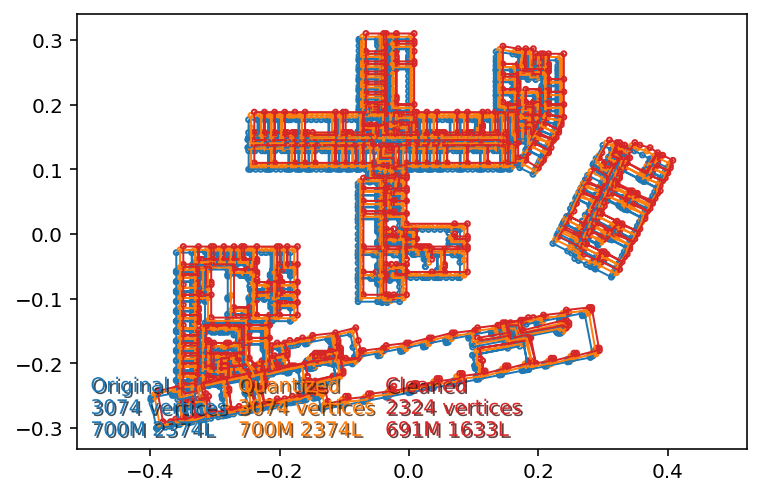

In [6]:
# Choose 0 as EOS so zero-padding just adds EOS tokens.
sequence_end_token = 0
line_start_token   = 1
next_vertex_token  = 2
code_tokens        = {sequence_end_token, line_start_token, next_vertex_token}


from typing import List, Tuple, Dict, Generator, TypeVar, Optional, Union
T = TypeVar('T', int, float)
Pos = Tuple[T, T]
PolyLineSet   = List[List[Pos]]
TokenTriplet  = Tuple[int, int, int]
TokenTriplets = List[TokenTriplet]


def quantize_path(path: MPath, *, n_bits, return_stats=False):
    verts = path.vertices
    center, scale = data_utils.find_center_scale(verts)
    verts_norm  = (verts - center) / scale
    verts_quant = data_utils.quantize_verts(verts_norm, n_bits=n_bits)
    qpath = MPath(verts_quant, path.codes)
    if not return_stats:
        return qpath
    else:
        return qpath, center, scale


def dequantize_path(path: MPath, *, n_bits):
    verts = data_utils.dequantize_verts(np.array(path.vertices), n_bits=n_bits)
    return MPath(verts, path.codes)


def path_to_polylines(path: MPath) -> PolyLineSet:
    polylines = []
    for code, vert in zip(path.codes, path.vertices):
        if code == MPath.CLOSEPOLY:
            vert = line[0]
            code = MPath.LINETO
        
        if code == MPath.MOVETO:
            polylines.append([])
        elif code == MPath.LINETO:
            prev_vert = polylines[-1][-1]
            # Some segments may have quantized to zero length.
            if np.allclose(vert, prev_vert):
                continue
        else:
            0/0
        
        polylines[-1].append(vert)
    
    return [np.array(line) for line in polylines]


def polylines_to_path(polylines: PolyLineSet) -> MPath:
    "Polylines into a Path"
    codes = []
    verts = []
    for line in polylines:
        codes.append(MPath.MOVETO)
        codes.extend([MPath.LINETO] * (len(line) - 1))
        verts.extend(line)
    return MPath(np.array(verts).reshape((-1, 2)), codes)


def split_segments(polylines: PolyLineSet) -> PolyLineSet:
    "Split set of polylines into set of constituent line segments"
    return [[a, b] for line in polylines for a, b in zip(line[:-1], line[1:])]


def stitch_segments(polylines: PolyLineSet) -> PolyLineSet:
    "Stitch together polylines that end where the previous started"
    out = []
    for line in polylines:
        if not (out and np.allclose(line[0], out[-1][-1])):
            out.append([])
        out[-1].extend(line)
    return [np.array(line) for line in out]


@data_utils.compose(list)
def remove_segments(polylines: PolyLineSet, *, min_area=1e-4) -> PolyLineSet:
    "Remove line segments that form small triangles"
    for line in stitch_segments(polylines):
        while line.shape[0] > 2:
            triplets = np.hstack((line[:-2,  None],
                                  line[1:-1, None],
                                  line[2:,   None]))
            A = np.dstack((triplets, np.ones((triplets.shape[0], 3, 1))))
            area = np.abs(0.5*np.linalg.det(A))
            smallest = np.argmin(area)
            if area[smallest] > min_area:
                break
            line = np.vstack((line[0:smallest+1], line[smallest+2:]))
        yield line


path_cmp  = MPath(data_utils.normalize_vertices(path.vertices), path.codes)
path_deq  = dequantize_path(quantize_path(path, n_bits=n_bits), n_bits=n_bits)
path_cln  = dequantize_path(polylines_to_path(remove_segments(path_to_polylines(quantize_path(path, n_bits=n_bits)))), n_bits=n_bits)

tb = dict(text_va='bottom', text_y=0.02)
plot_path(path_cmp, color='C0', label='Original',  text_x=0.02, zorder=10, shift=0.000, **tb)
plot_path(path_deq, color='C1', label='Quantized', text_x=0.24, zorder=20, shift=0.005, **tb)
plot_path(path_cln, color='C3', label='Cleaned',   text_x=0.46, zorder=30, shift=0.010, **tb)
plt.axis('equal')
plt.show()

### Flattening and Unflattening

Our deep network will, as we have established, consider the input as a 1D sequence. We have so far looked at $N\times{}3$ matrices, so let us define these two operations:

In [7]:
from itertools import groupby


@data_utils.compose(lambda it: np.array(list(it), dtype=int).reshape((-1, 3)))
def flatten_segments(polylines: PolyLineSet) -> TokenTriplets:
    "Flatten list of segments into a tensor of (triplets, 3)."
    for line in polylines:
        for i, vertex in enumerate(line):
            yield line_start_token if i == 0 else next_vertex_token
            yield from vertex
    yield from [sequence_end_token]*3


def unflatten_tokens(tokens: TokenTriplets) -> PolyLineSet:
    "Turn flattened tensor (triplets, 3) into list of segments."
    polylines = []
    for code, *qvert in tokens:
        if code == line_start_token:
            polylines.append([])
        elif code == next_vertex_token:
            pass
        elif code == sequence_end_token:
            assert qvert == [sequence_end_token, sequence_end_token]
            break
        else:
            raise ValueError(f'invalid opcode: {code}')
        polylines[-1].append(qvert)

    return [np.array(line) for line in polylines]


polylines = path_to_polylines(quantize_path(path, n_bits=n_bits))
polylines2 = unflatten_tokens(flatten_segments(polylines))
assert len(polylines) == len(polylines2)
assert all(np.all(polylines[i] == polylines2[i]) for i in range(len(polylines)))

#### Plot All Floorplans

Now we have all we need to make token sequences of our floorplans.

In [8]:
all_segment_sets = [path_to_polylines(quantize_path(floorplan_to_path(fplan), n_bits=n_bits)) for fplan in all_floorplans]
ex_list = [{'token_seq': flatten_segments(segs)} for segs in all_segment_sets]

And get them back out from our network, like so

In [9]:
%%script true
paths = [dequantize_path(polylines_to_path(unflatten_tokens(ex['token_seq'])), n_bits=n_bits) for ex in ex_list]
plot_paths(paths, text=False)

## Generating Training Data

To generate training examples from our floorplans, we imagine placing the robot at different points throughout the floorplan and saying, if you are here, you should generate this sequence of line segments. These line segments will be ordered by distance from the robot.

### Subdividing Polylines

We will need to break long line segments into some maximum length, otherwise a 1 km wall would need to be predicted.

In [10]:
@data_utils.compose(list)
def subdivide_segments(polylines: PolyLineSet, *, max_length: float,
                       eps=np.finfo(float).eps) -> PolyLineSet:
    for a, b in np.array(split_segments(polylines)):
        d = np.linalg.norm(b - a)
        # When n = 2, linspace returns [a,          b].
        # When n = 3, linspace returns [a, (a+b)/2, b].
        n = max(2, int(d / max_length - eps) + 2)
        yield np.linspace(a, b, n, dtype=a.dtype)

segs = np.array([[[0.0, 0.0], [0.0, 9.0]]])
assert subdivide_segments(segs, max_length=20.0)[0].tolist() == segs[0].tolist()
assert subdivide_segments(segs, max_length=10.0)[0].tolist() == segs[0].tolist()
assert subdivide_segments(segs, max_length=9.0)[0].tolist() == segs[0].tolist()
assert subdivide_segments(segs, max_length=5.0)[0][:, 1].tolist() == [0.0, 4.5, 9.0]
assert subdivide_segments(segs, max_length=8.0)[0][:, 1].tolist() == [0.0, 4.5, 9.0]
del segs

### Aside: Intersecting Paths

For visualization purposes, let us define an intersection operation using the subdivision operation:

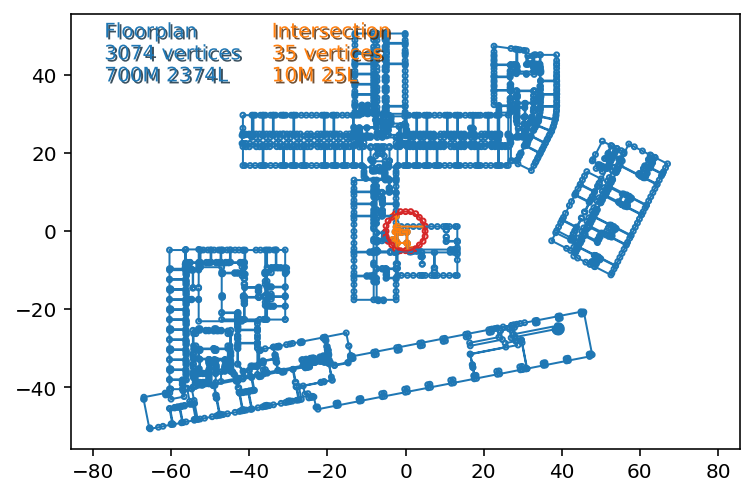

In [11]:
def intersect(path: MPath, polygon: MPath, subdivision) -> MPath:
    segs = subdivide_segments(path_to_polylines(path), max_length=subdivision)
    segs = split_segments(segs)
    segs_inside = [line for line in segs if np.any(polygon.contains_points(line))]
    return polylines_to_path(remove_segments(segs_inside))


p = np.r_[0.0, 0.0]
r = 5.0
path = floorplan_to_path(a_floorplan)

circle       = MPath.circle(p, r)
intersection = intersect(path, circle, subdivision=0.01)

plot_path(path,         color='C0', label='Floorplan',    text_x=0.05, zorder=10)
plot_path(intersection, color='C1', label='Intersection', text_x=0.30, zorder=20)
plot_path(circle,       color='C3',                       text=False,  zorder=100)
plt.axis('equal')

plt.show()
del p, r, path, circle, intersection

### Generating Valid Positions

We need to know which points are valid, i.e., where can you actually be inside a floorplan. We can use our knowledge of the "spaces" to sample such a point.

We use rejection sampling to ascertain a uniform distribution. Specifically, we sample a point within the extents of the floorplan, then see if that point is inside any of the spaces, otherwise we draw a new point and try again.

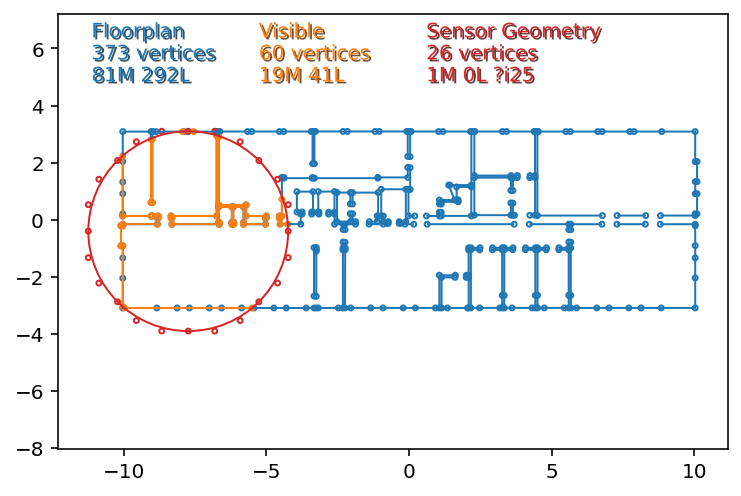

In [12]:
def _valid_positions_gen(floorplan: floorplans.FloorPlan) -> Pos:
    path = floorplan.to_path()
    center, _ = data_utils.find_center_scale(path.vertices)
    extents = path.get_extents()
    paths = [space.to_path() for space in floorplan.spaces]
    while True:
        p = np.random.uniform(extents.p0, extents.p1)
        if any(path and path.contains_point(p) for path in paths):
            yield p - center

                
from itertools import islice
def sample_valid_positions(floorplan, n) -> List[Pos]:
    gen = _valid_positions_gen(floorplan)
    poses = islice(gen, n)
    return np.array(list(poses))


some_floorplan = np.random.choice(all_floorplans)
path = floorplan_to_path(some_floorplan)
#path = quantize_path(path, n_bits=n_bits)

point, = sample_valid_positions(some_floorplan, 1)

# Just pretend we have unit scale, then convert to meters
radius = sensor_rangef(1.0)/QU

circle = MPath.circle(point, radius)
intersection = intersect(path, circle, subdivision=0.01)

plot_path(path,         color='C0', label='Floorplan',       text_x=0.05, zorder=10)
plot_path(intersection, color='C1', label='Visible',         text_x=0.30, zorder=20)
plot_path(circle,       color='C3', label='Sensor Geometry', text_x=0.55, zorder=100)
plt.axis('equal')
plt.show()
del point, radius, circle, intersection

### Spacing the Positions Maximally

Simply taking lots of random points in a floorplan will tend to give overlapping results, so we devise a method of taking a subset of the most distant points. Sample a set of points $P$, then for $i=1, 2, \ldots, N$, let $$ p_i = {\arg}\max_{p \, \in \, P \, \setminus \, S_{i-1}} \Big( \min_{p' \, \in \, S_{i-1}} {\|p - p'\|}_2 \Big) $$ where $ S_i = \{p_1, p_2, \ldots, p_i\} \subseteq P $ is the set of selected points at iteration $i$. We can also stop the process once the maximal distance goes below some threshold.

generated 500 valid positions
selected 26 distant positions


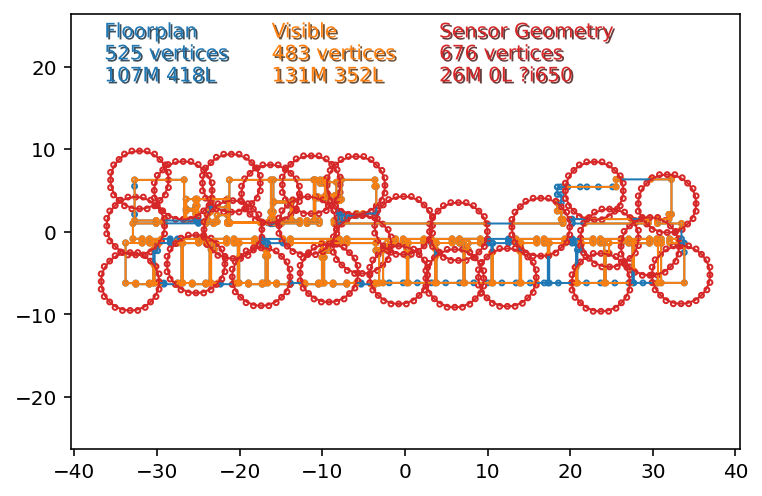

In [13]:
from scipy.spatial import distance_matrix

def maximum_distance_subset(points, *, n=None, min_dist=np.inf):
    n = n if n else len(points)
    dmat = distance_matrix(points, points)
    selected = np.zeros(len(points), dtype=bool)
    selected[0] = True
    while np.count_nonzero(selected) < n:
        dmin_subset = dmat[selected, :].min(axis=0)
        ind = np.argmax(dmin_subset)
        if dmin_subset[ind] < min_dist:
            break
        assert not selected[ind]
        selected[ind] = True
    return selected

some_floorplan = np.random.choice(all_floorplans)
path = floorplan_to_path(some_floorplan)

points = sample_valid_positions(some_floorplan, 500)
points = np.array(list(points))
print(f'generated {len(points)} valid positions')

radius = sensor_rangef(1.0)/QU
selected = maximum_distance_subset(points, min_dist=1.4*radius)
#selected = np.arange(len(points)) < 10
print(f'selected {np.count_nonzero(selected)} distant positions')

circle = MPath.make_compound_path(*[MPath.circle(p, radius) for p in points[selected]])
intersection = intersect(path, circle, subdivision=0.1)

plot_path(path,         color='C0', label='Floorplan',       text_x=0.05, zorder=10)
plot_path(intersection, color='C1', label='Visible',         text_x=0.30, zorder=20)
plot_path(circle,       color='C3', label='Sensor Geometry', text_x=0.55, zorder=100)
plt.axis('equal')
plt.show()
del some_floorplan, path, points, radius, selected, circle, intersection

### Sorting the Line Segments

Consider line segments instead, then we sort the line segments according to distance from our imagined point $p$ from before. This means we calculate the line-point distance for each line.

Consider the line segment $x = tx_1$ where $0\le t \le 1$. This represents a line segment from the origin to $x_1$. The projection $p_x$ of $p$ onto the line is $p\cdot{}\hat{x}_1$ with $\hat{x}_1 = x_1 \| x_1\|_2^{-1}$.

Projected points P_:
[[ 2.97633136  1.65680473]
 [-1.          0.        ]
 [ 5.          2.5       ]]
Projected parameter T_:
[0.66272189 0.         1.        ]


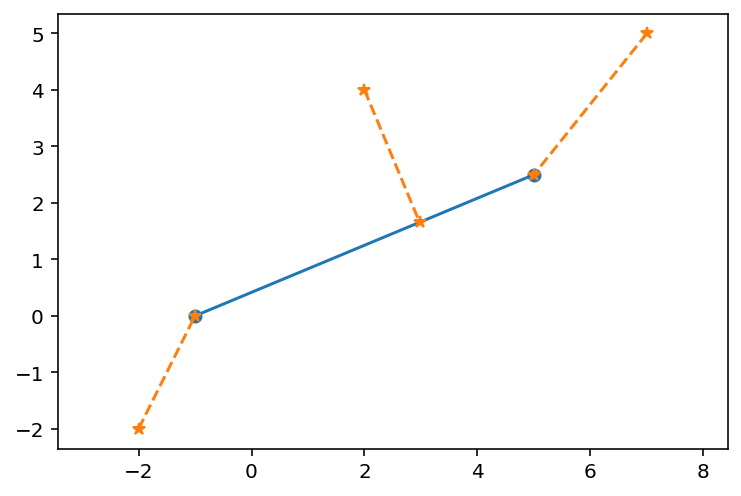

In [14]:
def project_point_line(x0, x1, P, *, clip=True):
    "Project points P onto line x0-x1"
    x1norm = np.linalg.norm(x1-x0)
    assert x1norm > 0.0
    x1unit = (x1-x0)/x1norm
    prods = np.dot(P-x0, x1unit)
    P_ = prods[:, None]*x1unit[None, :]
    T_ = prods/x1norm
    if clip:
        T_ = np.clip(T_, 0.0, 1.0)
        P_ = T_[:, None]*(x1 - x0)[None, :]
    return P_ + x0, T_

x0 = np.r_[-1.0, 0.0]
x1 = np.r_[ 5.0, 2.5]
P  = np.array([[ 2.0, 4.0], [-2, -2], [7.0, 5.0]])
# Let x0 = 0

P_, T_ = project_point_line(x0, x1, P)

plt.axis('equal')
plt.plot([x0[0], x1[0]], [x0[1], x1[1]], 'o-', color='C0')

# The line segment only exists between 0 <= t <= 1, so clip and reconstruct p'.

for i in range(len(P_)):
    plt.plot([P[i, 0], P_[i, 0]], [P[i, 1], P_[i, 1]], '*--', color='C1')
print('Projected points P_:')
print(P_)
print('Projected parameter T_:')
print(T_)

### Overlap Deduplication

Once we sort the lines, duplicate lines start to become an issue. These stem from many sources, such as issues with the dataset. But most of all, quantization can accidentally make some lines overlap - partially, or completely, or even make some lines supersets of others.

In [15]:
def _expand_overlapping(segs):
    """Deduplicate line segments by expanding them to their
    largest overlapping segment endpoints. For example, if three
    segments are situated like this (but on top of each other)
        --
         ---
           ----
    we generate three segments
        ----
        -------
         ------
    If this routine is applied again, the three segments will be
    identical and collapsed into one segment.
    """
    num_updated = 0
    segs = np.array(split_segments(segs), copy=True)
    
    for i, (a_i, b_i) in enumerate(segs):
        
        # Translate all segments s.t. current segment a = (0, 0) and ends at b = (x, y).
        segs_t = segs - a_i
        x_i, y_i = b_i = segs_t[i, 1]
        
        # Rotate all segments s.t. current segment ends at b' = (x', 0) where x' = |x, y|.
        norm = np.linalg.norm(b_i)
        assert norm > 0.0
        R = np.array([[x_i, -y_i],
                      [y_i,  x_i]])/norm
        segs_ = segs_t @ R
        
        # Shorthands. Segments span a-b, where a = (x1, y1) and b = (x2, y2).
        A_, B_  = segs_[:, 0, :], segs_[:, 1, :]
        X_, Y_  = segs_[:, :, 0], segs_[:, :, 1]
        X1_, Y1_ = A_[:, 0], A_[:, 1]
        X2_, Y2_ = B_[:, 0], B_[:, 1]
        
        assert np.allclose(A_[i], 0.0)
        assert np.isclose(Y2_[i], 0.0)
        
        # Flip segments (a,b) to (b,a) s.t. x1 <= x2.
        flip = X2_ < X1_
        A_[flip], B_[flip] = B_[flip].copy(), A_[flip].copy()
        assert np.all(X1_ <= X2_)
        
        # Segment is collinear if it's on the X axis
        collinear = np.isclose(Y1_, 0.0) & np.isclose(Y2_, 0.0)
        
        # Check if other segment's X coordinates are inside this line
        overlap_x1 = (0.0 <= X1_) & (X1_ <= X2_[i])
        overlap_x2 = (0.0 <= X2_) & (X2_ <= X2_[i])
        
        selection = collinear & (overlap_x1 | overlap_x2)
        
        x1_min = np.min(X1_[selection])
        x2_max = np.max(X2_[selection])
        
        updated = ((~np.isclose(X1_, x1_min) & overlap_x1)
                 | (~np.isclose(X2_, x2_max) & overlap_x2)) & collinear
        
        num_updated += np.count_nonzero(updated)
        
        X1_[collinear & overlap_x1] = x1_min
        X2_[collinear & overlap_x2] = x2_max
        
        # Invert and put back into original array
        segs[selection] = (segs_[selection] @ R.T) + a_i
        
    return segs, num_updated


def filter_null_segments(polylines):
    segs = np.array(split_segments(polylines))
    return segs[~np.all(np.isclose(segs[:, 0], segs[:, 1]), axis=1)]


def dedupe_polylines(polylines):
    "Deduplicate segments by expanding and removing duplicate segments."
    segs = filter_null_segments(polylines)
    n = len(segs)
    # Routine needs to run N^2 times at worst.
    for i in range(n**2):
        segs, num_updated = _expand_overlapping(segs)
        if num_updated == 0:
            break
    segs = np.unique(segs, axis=0)
    return segs

some_floorplan = np.random.choice(all_floorplans)
path = floorplan_to_path(some_floorplan)
qpath = quantize_path(path, n_bits=n_bits)
polylines = path_to_polylines(qpath)

%timeit dedupe_polylines(polylines)

516 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let us compare an untouched polyline set, a deduplicated one, and a deduplicated and subdivided one.

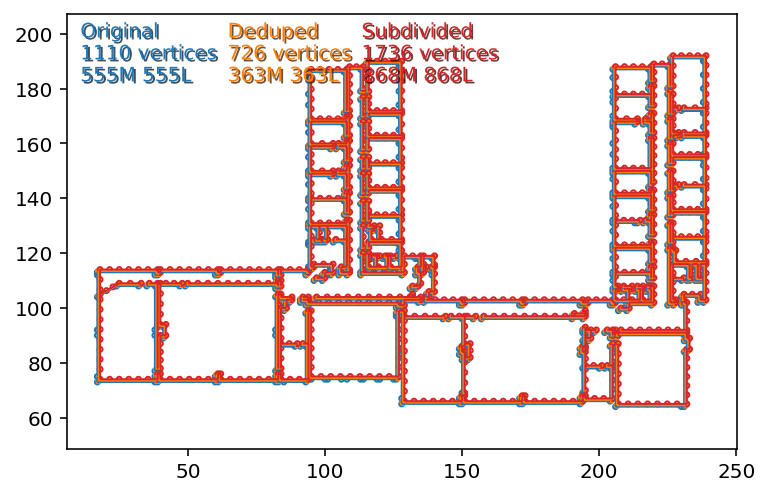

In [16]:
segs = split_segments(polylines)
dedup = dedupe_polylines(polylines)
subdiv = split_segments(subdivide_segments(dedup, max_length=4.0))
#pl = (dedupe_polylines(pl))
#print(len(pl))
plot_path(polylines_to_path(segs),   label='Original',   color='C0', text_x=0.02, shift=0.0, zorder=10)
plot_path(polylines_to_path(dedup),  label='Deduped',    color='C1', text_x=0.24, shift=0.5, zorder=20)
plot_path(polylines_to_path(subdiv), label='Subdivided', color='C3', text_x=0.44, shift=1.0, zorder=30)
plt.axis('equal')
del dedup, segs

### Splitting at Intersections

Deduplication will result in line segments that connect somewhat unintuitively, for example, a long wall with 90 degree connecting walls will be represented as one long line segment with the perpendicular walls' endpoint ending up in the middle somewhere. This yields an undesirable degree of freedom.

Instead, we canonicalize with the invariant that line segments cannot cross, but may only connect at endpoints.

In [17]:
def split_intersections(segs, *, dtype=None):
    "Split each segment whereever another segment crosses"
    
    dtype = segs.dtype if dtype is None else dtype
    
    # Compute in float, cast back to dtype after.
    segs = np.array(split_segments(segs), dtype=np.float64, copy=True)
    
    out = []
    
    # Iterate over each line, split at its intersections.
    for i, (a_i, b_i) in enumerate(segs):
        
        # Translate all segments s.t. current segment a = (0, 0) and ends at b = (x, y).
        segs_t = segs - a_i
        x_i, y_i = b_i = segs_t[i, 1]
        
        # Rotate all segments s.t. current segment ends at b' = (x', 0) where x' = |x, y|.
        norm   = np.linalg.norm(b_i)
        R = np.array([[x_i, -y_i],
                      [y_i,  x_i]])/norm
        segs_ = segs_t @ R
        
        # Shorthands. Segments span a-b, where a = (x1, y1) and b = (x2, y2).
        A_, B_  = segs_[:, 0, :], segs_[:, 1, :]
        X_, Y_  = segs_[:, :, 0], segs_[:, :, 1]
        X1_, Y1_ = A_[:, 0], A_[:, 1]
        X2_, Y2_ = B_[:, 0], B_[:, 1]
        
        assert np.allclose(A_[i], 0.0)
        assert np.isclose(Y2_[i], 0.0)
        
        # Flip segments (a,b) to (b,a) s.t. x1 <= x2.
        flip = X2_ < X1_
        A_[flip], B_[flip] = B_[flip].copy(), A_[flip].copy()
        assert np.all(X1_ <= X2_)
        
        # Compute X intercept for all segments, i.e., where y = 0. We define the
        # segments parametrically by (x, y) = (1 - t)a + tb where 0 <= t <= 1.
        # Now we can deduce the X intercept:
        #
        #  0.      y = 0                 premise
        #  1.      x = (1-t)x1 + tx2     definition
        #  2.      y = (1-t)y1 + ty2     definition
        #  3.      y = y1 - ty1 + ty2    expand parentheses
        #  4.      y = y1 + ty2 - ty1    switch last two terms
        #  5.      y = y1 + t(y2 - y1)   factor t
        #  6.      0 = y1 + t(y2 - y1)   subst. 0 into 5
        #  7.    -y1 = t(y2 - y1)        subtract y1
        #  8.      t = -y1/(y2 - y1)     divide, switch RHS/LHS
        #  9.      t = y1/(y1 - y2)      factor negation into denom
        # 10.      x = x1 + t(x2 - x1)   analogous to 2-5
        # 11.      x = x1 + (y1/(y1 - y2))(x2 - x1)
        #                                subst. 9 into 10
        # If y1 = y2, the X intercept is undefined.
        with np.errstate(divide='ignore', invalid='ignore'):
            T_ = Y1_/(Y1_ - Y2_)
            X_int = X1_ + T_*(X2_ - X1_)
        
        # We want to find segmenst whose X intercept lies in the
        # i'th segment's _interior_. If it is on the boundary, no
        # splitting is necesasry. Note that this filters out NaNs.
        overlap = (0.0 < X_int) & (X_int < X2_[i])
        
        # The X intercept is must lie inside the segment, i.e., 0 <= t <= 1.
        inside  = (0.0 <= T_) & (T_ <= 1.0)

        # X_out is a sequence of X coordinates where we want to cut.
        X_out = np.array([X1_[i], *X_int[overlap & inside], X2_[i]])
        
        # Remove multiple cuts at the same X coordinate.
        X_out = np.unique(X_out)
        
        # Create segments from pairs of X coordinates, let their y = 0.
        Y_out = np.zeros(len(X_out) - 1)
        segs_out = np.c_[X_out[:-1], Y_out,
                         X_out[1:],  Y_out].reshape(-2, 2, 2)
        
        # X coordinates must be strictly increasing.
        assert np.all(segs_out[:, 0, 0] < segs_out[:, 1, 0])
        
        # Invert rotation and translation.
        out.extend((segs_out @ R.T) + a_i)

    # Cast
    out = np.array(out, dtype=dtype)
    
    # Remove zero-length segments, happens because of integer truncation.
    out = out[~np.all(np.isclose(out[:, 0], out[:, 1]), axis=1)]
    
    return out


dedup = dedupe_polylines(polylines)
%timeit split_intersections(dedup)

122 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Line segment length: µ=3.5806, σ=1.2051, min=1, max=5


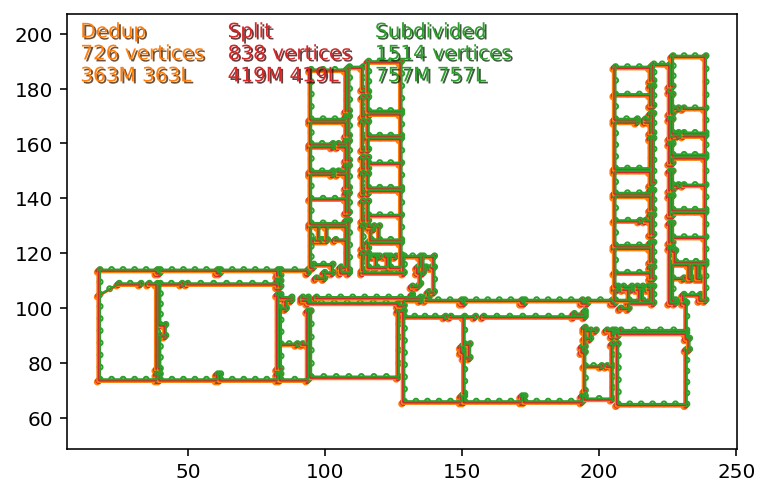

In [18]:
segs   = split_segments(polylines)
dedup  = dedupe_polylines(segs)
split  = split_intersections(dedup)
subdiv = subdivide_segments(split, max_length=5.0)
subdiv = np.array(split_segments(subdiv))
plot_path(polylines_to_path(dedup),  color='C1', label='Dedup',      text_x=0.02, shift=0.0, zorder=10)
plot_path(polylines_to_path(split),  color='C3', label='Split',      text_x=0.24, shift=0.5, zorder=20)
plot_path(polylines_to_path(subdiv), color='C2', label='Subdivided', text_x=0.46, shift=1.0, zorder=30)
plt.axis('equal')
seglens = np.linalg.norm(subdiv[:, 0, :] - subdiv[:, 1, :], axis=1)
print('Line segment length:', data_utils.statstr(seglens))
del segs, split, subdiv, seglens

### Dedupe, Split, Subdivide, Sort

We're now ready to put it all together.

In [19]:
def sorted_segments(segs: PolyLineSet, p: Pos):
    "Sort segments in order of increasing distance from the given point"
    points = np.array([project_point_line(a, b, [p])[0][0] for a, b in segs])
    dists  = np.linalg.norm(points - p, axis=1)
    inds   = np.argsort(dists)
    return segs[inds], points[inds], dists[inds]

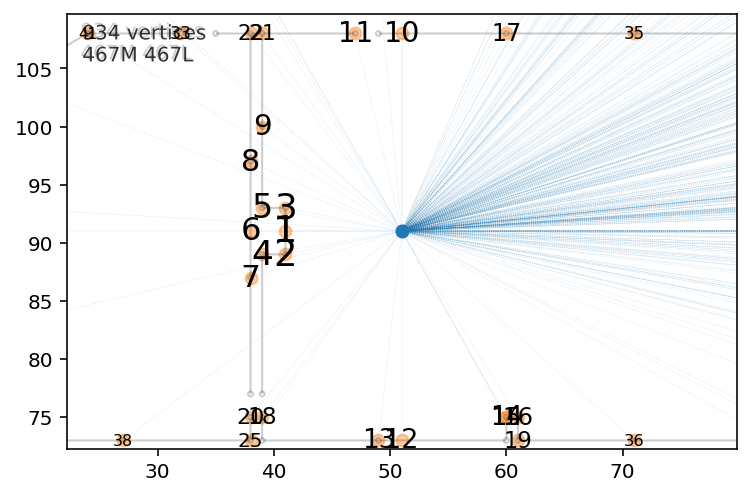

In [20]:
path = floorplan_to_path(some_floorplan)

p, = sample_valid_positions(some_floorplan, 1)

def path_to_cleaned_segments(path):
    center, scale = data_utils.find_center_scale(path.vertices)
    segs = np.array(split_segments(path_to_polylines(path)))
    segs = (segs - center) / scale
    segs = data_utils.quantize_verts(segs, n_bits=n_bits)
    segs = dedupe_polylines(segs)
    segs = split_intersections(segs)
    segs = subdivide_segments(segs, max_length=max_seg_lenf(scale))
    segs = np.array(split_segments(segs))
    return segs, center, scale

unsorted_segs, center, scale = path_to_cleaned_segments(path)
p_ = data_utils.quantize_verts((p - center) / scale)
segs, points, dists = sorted_segments(unsorted_segs, p_)

# Plot 'em
ax = plt.gca()
ax.scatter(p_[0], p_[1], color='C0')
ax.scatter(points[:, 0], points[:, 1], alpha=0.4, color='C1')

plot_path(polylines_to_path(segs), ax=ax, color=(0,0,0,0.2))

# Lines from p_ to each interesction
from matplotlib.collections import LineCollection
lcol = LineCollection([[p_, pi] for pi in points], linestyle='--', linewidth=0.2, alpha=0.2)
ax.add_collection(lcol)

# Sequence numbers
for i, (x, y) in enumerate(points[:100], 1):
    ax.text(x, y, i, ha='center', va='center', fontsize=400/(0.8*i+20), clip_on=True)

r = 1.1*dists[9]
xlim, ylim = p_[:, None] + (-r, r)
ax.set(xlim=xlim, ylim=ylim)
ax.set_aspect('equal', adjustable='datalim')

### Applying to All Floorplans

We now have the tools necessary to generate our dataset, which is parameterized by a combination of positions and floorplans. We will cover each floorplan in maximally-distant points, then order the segments of the floorplan from that point-of-view.

In [21]:
ex_list = []
ex_list_per_floorplan = []

for i, floorplan in enumerate(all_floorplans):
    print(f'{i+1:-4d}/{len(all_floorplans)}: {floorplan}')
    ex_list_per_floorplan.append([])
    
    path = floorplan_to_path(floorplan)
    qsegs, center, scale = path_to_cleaned_segments(path)
    print(f'{len(qsegs)} segments (scale {scale:.5g} m, or {scale/(2**n_bits):.5g} m/u)')

    points = sample_valid_positions(floorplan, num_positions)
    points = data_utils.quantize_verts((points - center) / scale)
    selected = maximum_distance_subset(points, min_dist=sensor_rangef(scale))
    print(f'selected {np.count_nonzero(selected)}/{len(points)} positions')
    
    for point in points[selected]:
        qsegs_near, _, qdists = sorted_segments(qsegs, point)
        # Cap the number of lines in an example
        qsegs_near = qsegs_near[:num_segments]
        ex_list.append({'floorplan': floorplan.filepath,
                        'path': path,
                        'position': point,
                        'segments_quantized': qsegs_near,
                        'triplets': flatten_segments(qsegs_near)})
        ex_list_per_floorplan[-1].append(ex_list[-1])
    print()

   1/171: FloorPlan(domain='KTH', floor_name='0510045922_A-40', building_name='A0093001', filepath=PosixPath('/home/lericson/ds/KTH_CampusValhallavagen_Floorplan_Dataset_RAW/A0093001/0510045922_A-40.1-030.xml'))
1582 segments (scale 168.07 m, or 0.65653 m/u)
selected 144/300 positions

(and so on...)
 170/171: FloorPlan(domain='KTH', floor_name='50056458', building_name='A0050001', filepath=PosixPath('/home/lericson/ds/KTH_CampusValhallavagen_Floorplan_Dataset_RAW/A0050001/50056458.xml'))
245 segments (scale 56.803 m, or 0.22189 m/u)
selected 41/300 positions

 171/171: FloorPlan(domain='KTH', floor_name='50056459', building_name='A0050001', filepath=PosixPath('/home/lericson/ds/KTH_CampusValhallavagen_Floorplan_Dataset_RAW/A0050001/50056459.xml'))
277 segments (scale 57.147 m, or 0.22323 m/u)
selected 41/300 positions



In [22]:
from data_utils import statstr
print('#examples:', len(ex_list))
print('triplets/ex:', statstr([len(ex['triplets']) for ex in ex_list]))

#examples: 7774
triplets/ex: µ=100.79, σ=2.9252, min=43, max=101


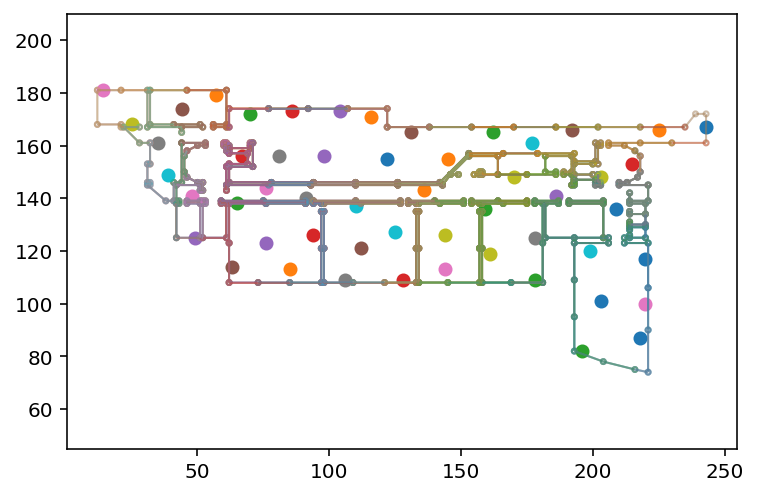

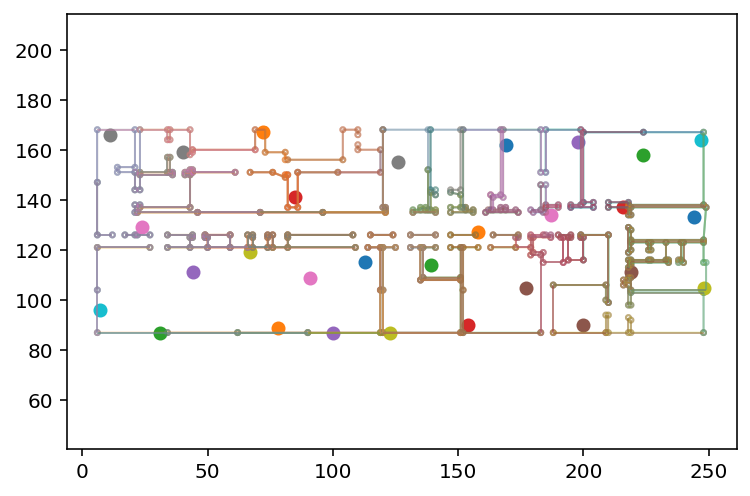

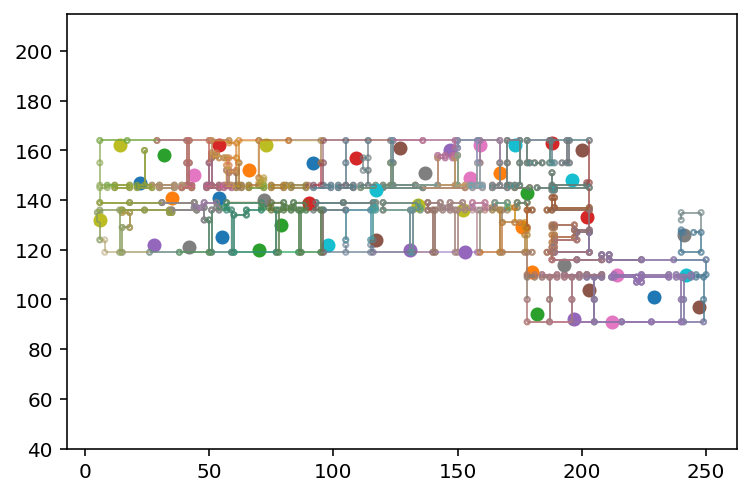

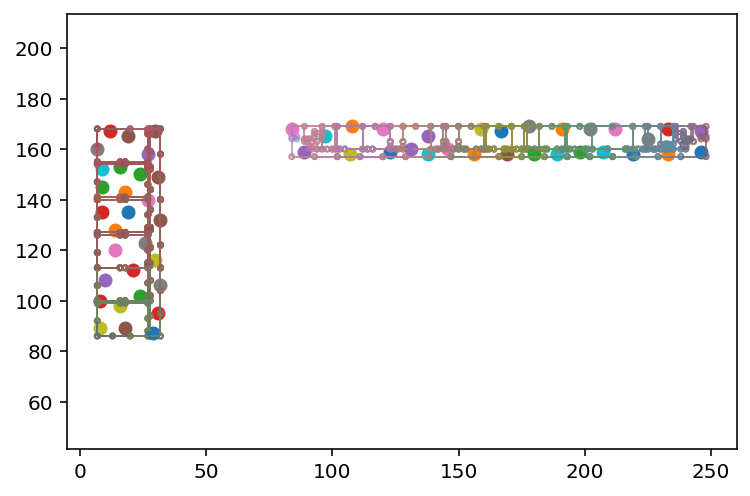

In [30]:
for i, index in enumerate(np.random.choice(len(ex_list_per_floorplan), size=4)):
    ex_sublist = ex_list_per_floorplan[index]
    if not ex_sublist:
        continue
    for j, ex in enumerate(ex_sublist):
        color = f'C{j}'
        plt.scatter(*ex['position'], color=color)
        plot_path(polylines_to_path(ex['segments_quantized']), color=color, alpha=0.3, text=False)
    plt.axis('equal')
    #plt.axis('off')
    #plt.savefig(f"out{i}.pdf")
    plt.show()

### Training and validation TF datasets

In [24]:
# Shuffle the input data by sampling a random permutation
np.random.shuffle(ex_list)

# Split into training and validation sets
N         = len(ex_list)
split_pct = 0.9
split_idx = int(N*split_pct) - 1
train_ex_list, val_ex_list = ex_list[:split_idx], ex_list[split_idx:]

print(f'{len(train_ex_list)} training examples')
print(f'{len(val_ex_list)} validation examples')

6995 training examples
779 validation examples


In [25]:
train_ds = tf.data.Dataset.from_generator(
    lambda: ({'triplets': ex['triplets']} for ex in train_ex_list),
    output_types={'triplets': tf.int32},
    output_shapes={'triplets': tf.TensorShape([None, 3])}
)


val_ds = tf.data.Dataset.from_generator(
    lambda: ({'triplets': ex['triplets']} for ex in val_ex_list),
    output_types={'triplets': tf.int32},
    output_shapes={'triplets': tf.TensorShape([None, 3])}
)


def jitter_triplets(ex):
    opcodes = ex['triplets'][..., 0]
    verts   = ex['triplets'][..., 1:]
    verts   = modules.random_signed_perm(verts, n_bits=n_bits)
    verts   = modules.random_shift(verts, n_bits=n_bits)
    with tf.control_dependencies([tf.assert_less_equal(verts, 2**n_bits - 1)]):
        # Zero vertices of EOS ops
        cond    = tf.not_equal(opcodes, 0)
        verts   = tf.where(cond, verts, tf.zeros_like(verts))
        ex['triplets'] = tf.stack((opcodes, verts[..., 0], verts[..., 1]), axis=-1)
        return ex


def tokens_from_triplets(ex):
    opcodes   = ex['triplets'][..., 0]
    verts     = ex['triplets'][..., 1:]
    verts_adj = verts + len(code_tokens)
    with tf.control_dependencies([tf.assert_less(opcodes, len(code_tokens))]), \
         tf.control_dependencies([tf.assert_less(verts, 2**n_bits)]):
        triplets = tf.stack((opcodes, verts_adj[..., 0], verts_adj[..., 1]), axis=-1)
        ex['tokens'] = tf.reshape(triplets, [-1])
        ex['tokens_mask'] = tf.ones_like(ex['tokens'])
    return ex


mapped = train_ds.map(jitter_triplets).map(tokens_from_triplets)
batched = mapped.padded_batch(4, mapped.output_shapes)
batch = batched.make_one_shot_iterator().get_next()
#batch = train_ds.padded_batch(18, train_ds.output_shapes).make_one_shot_iterator().get_next()

Generated 1749 batches with 4 ex/batch


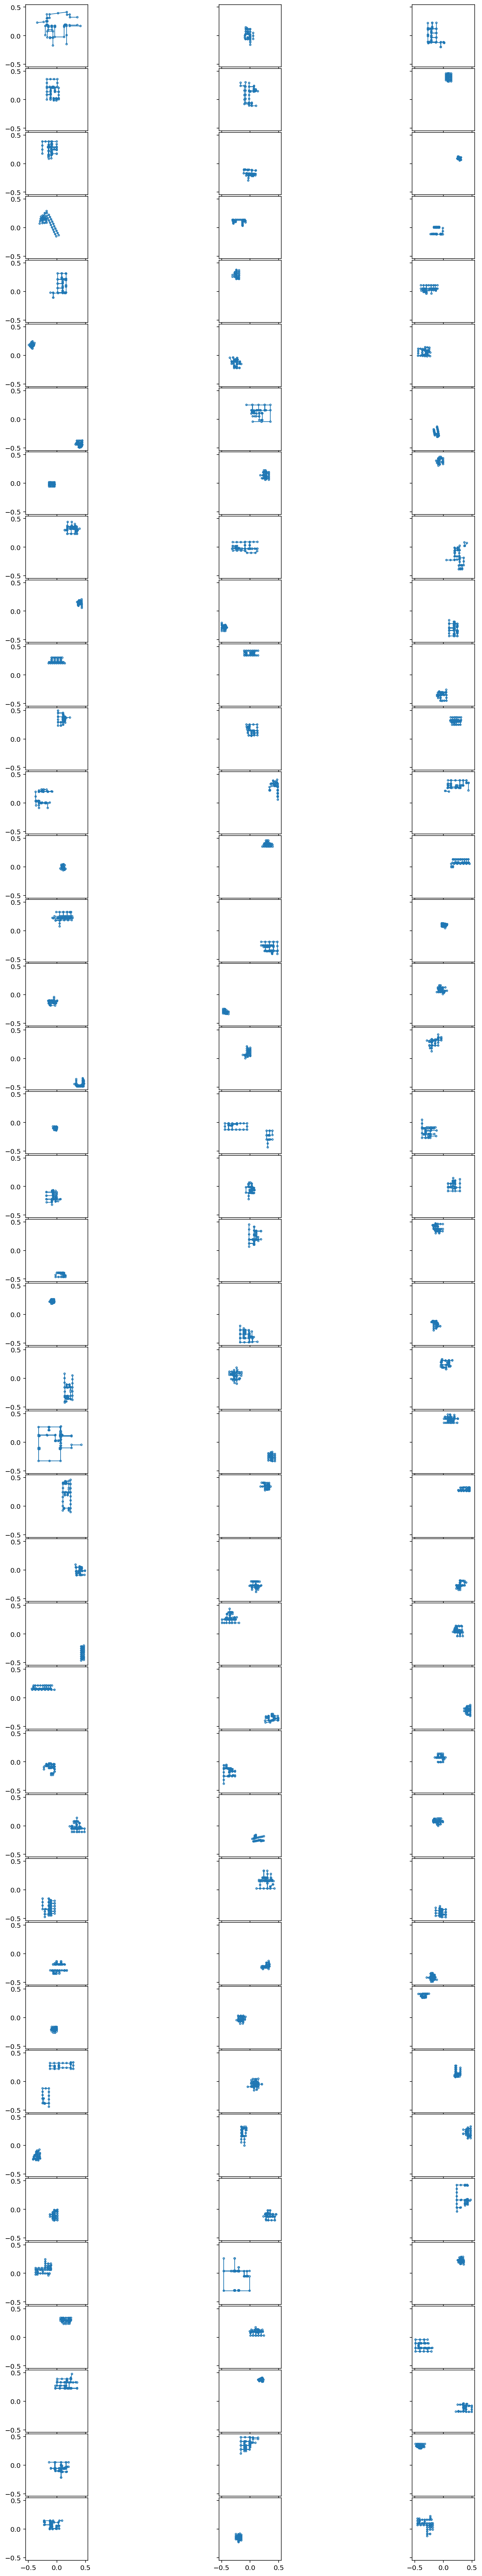

In [26]:
# Dry-run the TF dataset generator
with tf.Session(config=config) as sess:
    batches_np = [sess.run(batch) for bn in range(int(len(train_ex_list)/4+0.5))]

print(f'Generated {len(batches_np)} batches with '
      f'{len(batches_np[0]["triplets"])} ex/batch')

# Plot the output for ocular inspection
paths = []
for batch_np in batches_np[:30]:
    for i in range(batch_np['triplets'].shape[0]):
        triplets = batch_np['triplets'][i]
        segs = unflatten_tokens(triplets)
        qpath = polylines_to_path(segs)
        path = dequantize_path(qpath, n_bits=n_bits)
        paths.append(path)
plot_paths(paths, text=False)
del batches_np, batch_np, paths, path